# Import Data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from model.prediction_engine import get_final_data
# final_data = get_final_data(save_to_csv=False)
final_data = pd.read_csv('data/final_data.csv')

## Process Data

In [2]:
import torch
import tensorly as tl
%load_ext autoreload
%autoreload 2

from model.prediction_engine import PredictionTestEngine

final_data = final_data.sort_values(['year_month', 'GVKEY'])
final_data['trt1m'] = pd.to_numeric(final_data['trt1m'], errors='coerce')

# feature columns
feature_cols = [c for c in final_data.columns 
                if c not in ['GVKEY','year_month','trt1m']]
for col in feature_cols:
    final_data[col] = pd.to_numeric(final_data[col], errors='coerce')

# Build Y (T × n_series)
Y_df = (final_data
    .pivot_table(index='year_month', columns='GVKEY', 
                 values='trt1m', aggfunc='mean')
    .sort_index().sort_index(axis=1)
)
Y_df = Y_df.apply(lambda x: (x - x.mean())/x.std(), axis=0)
Y = Y_df.to_numpy()

# Build X tensor (T × n_series × n_features)
X_list = []
for col in feature_cols:
    pivot = (final_data
        .pivot_table(index='year_month', columns='GVKEY', 
                     values=col, aggfunc='mean')
        .reindex(index=Y_df.index, columns=Y_df.columns)
    )
    pivot = pivot.apply(lambda x: (x - x.mean())/x.std(), axis=0)
    X_list.append(pivot.to_numpy())
X = np.stack(X_list, axis=2)

# Shift so that X[t] predicts Y[t+1]
X_all = np.nan_to_num(X[:-1, :, :])
Y_all = np.nan_to_num(Y[1:, :])

# Time index for the test (use first day of month)
time_index_all = pd.to_datetime(Y_df.index[1:], format='%Y-%m')

# Ensure tensorly backend
tl.set_backend("pytorch")
# torch.set_default_tensor_type(torch.DoubleTensor)
torch.set_default_dtype(torch.float64)



# Linear Regression

X_all shape: (275, 127, 38)
Y_all shape: (275, 127)
Number of assets: 127
Prediction engine window size: 50
Calculated prediction engine train start index (start of test set): 247
Portfolio optimizer: long_short
Historical data lookback: 60
Rebalance frequency: 1
Prediction method: ridge
Prediction kwargs: {}
Initializing PredictionTestEngine...
PredictionTestEngine initialized. Train start index: 247, Test indices count: 28
Running prediction method: ridge to get expected returns (mu)...
run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=50, n_series=127, n_features=38
run_window: number of test windows=28


Rolling prediction: 100%|██████████| 28/28 [00:00<00:00, 425.00it/s]


Predictions generated. Shape: (28, 127). Metrics: {'mse': 1.2074569213026667, 'r2': -0.005885704341398901, 'directional_accuracy': np.float64(0.5407761529808774)}
Starting rolling backtest with portfolio optimizer: long_short...


Rolling Backtest (long_short): 100%|██████████| 28/28 [00:00<00:00, 14477.38it/s]

Rolling backtest with long_short completed.

Portfolio Backtest Results:
            portfolio_return  weight_1078  weight_1209  weight_1300  \
year_month                                                            
2021-09-01          0.264672    -0.008333     0.008333     0.008333   
2021-10-01         -0.124551    -0.008333    -0.008333     0.008333   
2021-11-01         -0.044838    -0.008333    -0.008333     0.008333   
2021-12-01          0.076383    -0.008333    -0.008333     0.008333   
2022-01-01          0.298501    -0.008333    -0.008333     0.008333   

            weight_1380  weight_1598  weight_1686  weight_1794  weight_1913  \
year_month                                                                    
2021-09-01     0.000000    -0.008333     0.008333     0.000000    -0.008333   
2021-10-01    -0.008333     0.008333     0.008333     0.000000    -0.008333   
2021-11-01    -0.008333    -0.008333     0.008333     0.000000    -0.008333   
2021-12-01    -0.008333    -0.0083

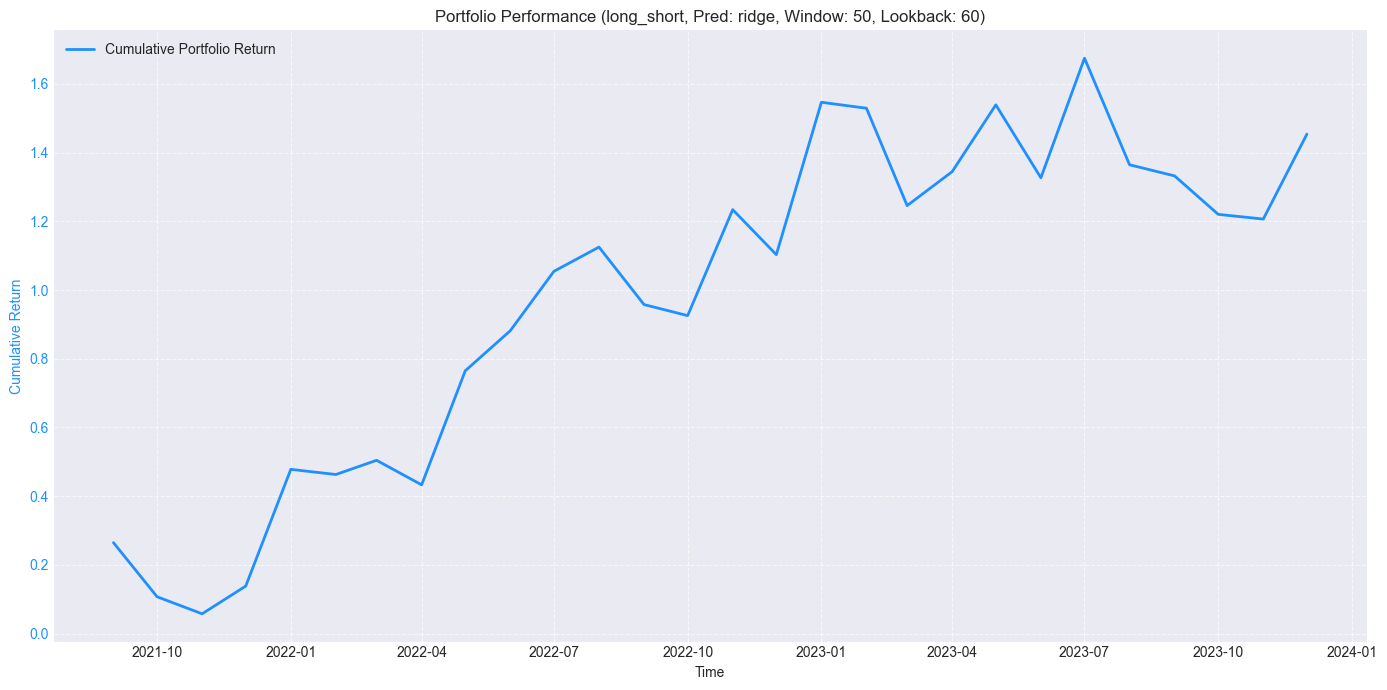

In [55]:
from model.prediction_engine import run_rolling_portfolio_backtest, plot_portfolio_performance
import warnings # Import the warnings module

# Define parameters for the backtest
pred_engine_window_size = 50 # Window size for the PredictionTestEngine
train_start_ratio = 0.9 # Use 70% of data for the initial training period of PredictionTestEngine

# Calculate pred_engine_train_start based on the ratio
# This is the index in X_all/Y_all where the *test set* begins.
# The training data for the first prediction will be X_all[pred_engine_train_start - pred_engine_window_size : pred_engine_train_start]
pred_engine_train_start = int(train_start_ratio * X_all.shape[0])

# Ensure pred_engine_train_start is valid
if pred_engine_train_start < pred_engine_window_size:
    print(f"Warning: Calculated pred_engine_train_start ({pred_engine_train_start}) is less than pred_engine_window_size ({pred_engine_window_size}). Adjusting to window_size.")
    pred_engine_train_start = pred_engine_window_size

if pred_engine_train_start >= X_all.shape[0]:
    raise ValueError(f"Error: pred_engine_train_start ({pred_engine_train_start}) must be less than total data length ({X_all.shape[0]}) to have a test set.")

asset_names = Y_df.columns.tolist() # Get asset names from your Y_df

# Parameters for portfolio construction
hist_data_lookback = 60             # Lookback period for historical data (used by HRP, MVO, MinVol)
portfolio_optimizer_method = "long_short"  # "top_k" or "long_short"
rebalance_freq = 1                 # Rebalance frequency

pred_method_name = "ridge"        # Prediction method
pred_method_kwargs= {}

# MVO-specific parameters (will be ignored by HRP but kept for potential switch back or if using MVO-based objectives)
mvo_target_objective = 'max_sharpe'
# EF common parameters (HRP doesn't use EfficientFrontier, but good to have if switching to MVO/MinVol)
ef_max_asset_weight = 0.1
ef_min_asset_weight = 0

print(f"X_all shape: {X_all.shape}")
print(f"Y_all shape: {Y_all.shape}")
print(f"Number of assets: {len(asset_names)}")
print(f"Prediction engine window size: {pred_engine_window_size}")
print(f"Calculated prediction engine train start index (start of test set): {pred_engine_train_start}")
print(f"Portfolio optimizer: {portfolio_optimizer_method}")
print(f"Historical data lookback: {hist_data_lookback}")
print(f"Rebalance frequency: {rebalance_freq}")
print(f"Prediction method: {pred_method_name}")
print(f"Prediction kwargs: {pred_method_kwargs}")

# Call the backtesting function
try:
    # Suppress warnings specifically from pypfopt for this block
    warnings.filterwarnings("ignore", module="pypfopt.*")
    
    portfolio_results_df = run_rolling_portfolio_backtest(
        X_features=X_all,
        y_returns_full=Y_all,
        pred_engine_window_size=pred_engine_window_size,
        asset_names=asset_names,
        hist_data_lookback=hist_data_lookback, # Using generic lookback
        pred_method_name=pred_method_name,
        pred_method_kwargs=pred_method_kwargs,
        pred_engine_train_start=pred_engine_train_start, 
        pred_engine_time_index=time_index_all, 
        pred_engine_n_jobs=1, # Set to > 1 for parallel prediction (e.g., 4 or os.cpu_count())
        
        portfolio_optimizer_method=portfolio_optimizer_method, 
        rank_k = 60,
        
        # rebalance_freq=rebalance_freq,
        
        # # MVO/EF specific parameters (passed but ignored by HRP logic in the function)
        # mvo_risk_free_rate_per_period=0.0, 
        # mvo_target_objective=mvo_target_objective,
        # ef_max_asset_weight=ef_max_asset_weight,
        # ef_min_asset_weight=ef_min_asset_weight,
        # ef_solver=None, 
        
        verbose=True # Keep this True for your custom function prints
    )

    print("\nPortfolio Backtest Results:")
    print(portfolio_results_df.head())

    # Plot the results
    plot_portfolio_performance(
        results_df=portfolio_results_df, 
        asset_names=asset_names,
        title_suffix=f"({portfolio_optimizer_method}, Pred: {pred_method_name}, Window: {pred_engine_window_size}, Lookback: {hist_data_lookback})"
    )

except ImportError as e:
    print(f"ImportError: {e}. Please ensure PyPortfolioOpt and other dependencies are installed.")
    print("You might need to run: pip install PyPortfolioOpt")
except ValueError as e:
    print(f"ValueError during backtest: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Reset warning filters to default after the try block
    warnings.resetwarnings()

# Ridge Regression

X_all shape: (275, 127, 38)
Y_all shape: (275, 127)
Number of assets: 127
Prediction engine window size: 50
Calculated prediction engine train start index (start of test set): 247
Portfolio optimizer: long_short
Historical data lookback: 60
Rebalance frequency: 1
Prediction method: linear_regression
Prediction kwargs: {}
Initializing PredictionTestEngine...
PredictionTestEngine initialized. Train start index: 247, Test indices count: 28
Running prediction method: linear_regression to get expected returns (mu)...
run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=50, n_series=127, n_features=38
run_window: number of test windows=28


Rolling prediction: 100%|██████████| 28/28 [00:00<00:00, 141.43it/s]


Predictions generated. Shape: (28, 127). Metrics: {'mse': 1.2074908784221239, 'r2': -0.005913992705496973, 'directional_accuracy': np.float64(0.5404949381327334)}
Starting rolling backtest with portfolio optimizer: long_short...


Rolling Backtest (long_short): 100%|██████████| 28/28 [00:00<00:00, 15027.58it/s]

Rolling backtest with long_short completed.

Portfolio Backtest Results:
            portfolio_return  weight_1078  weight_1209  weight_1300  \
year_month                                                            
2021-09-01          0.264672    -0.008333     0.008333     0.008333   
2021-10-01         -0.124551    -0.008333    -0.008333     0.008333   
2021-11-01         -0.044838    -0.008333    -0.008333     0.008333   
2021-12-01          0.076383    -0.008333    -0.008333     0.008333   
2022-01-01          0.298501    -0.008333    -0.008333     0.008333   

            weight_1380  weight_1598  weight_1686  weight_1794  weight_1913  \
year_month                                                                    
2021-09-01     0.000000    -0.008333     0.008333     0.000000    -0.008333   
2021-10-01    -0.008333     0.008333     0.008333     0.000000    -0.008333   
2021-11-01    -0.008333    -0.008333     0.008333     0.000000    -0.008333   
2021-12-01    -0.008333    -0.0083

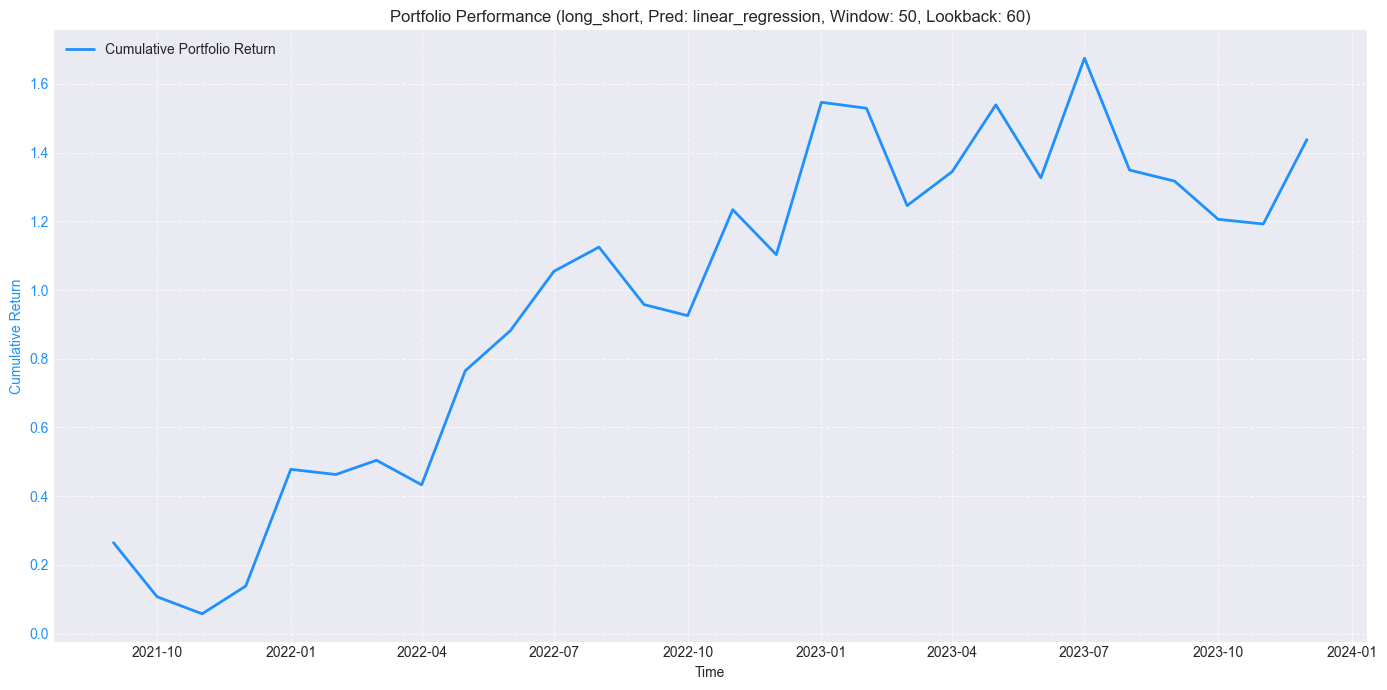

In [56]:
from model.prediction_engine import run_rolling_portfolio_backtest, plot_portfolio_performance
import warnings # Import the warnings module

# Define parameters for the backtest
pred_engine_window_size = 50 # Window size for the PredictionTestEngine
train_start_ratio = 0.9 # Use 70% of data for the initial training period of PredictionTestEngine

# Calculate pred_engine_train_start based on the ratio
# This is the index in X_all/Y_all where the *test set* begins.
# The training data for the first prediction will be X_all[pred_engine_train_start - pred_engine_window_size : pred_engine_train_start]
pred_engine_train_start = int(train_start_ratio * X_all.shape[0])

# Ensure pred_engine_train_start is valid
if pred_engine_train_start < pred_engine_window_size:
    print(f"Warning: Calculated pred_engine_train_start ({pred_engine_train_start}) is less than pred_engine_window_size ({pred_engine_window_size}). Adjusting to window_size.")
    pred_engine_train_start = pred_engine_window_size

if pred_engine_train_start >= X_all.shape[0]:
    raise ValueError(f"Error: pred_engine_train_start ({pred_engine_train_start}) must be less than total data length ({X_all.shape[0]}) to have a test set.")

asset_names = Y_df.columns.tolist() # Get asset names from your Y_df

# Parameters for portfolio construction
hist_data_lookback = 60             # Lookback period for historical data (used by HRP, MVO, MinVol)
portfolio_optimizer_method = "long_short"  # "top_k" or "long_short"
rebalance_freq = 1                 # Rebalance frequency

pred_method_name = "linear_regression"        # Prediction method
pred_method_kwargs= {}

# MVO-specific parameters (will be ignored by HRP but kept for potential switch back or if using MVO-based objectives)
mvo_target_objective = 'max_sharpe'
# EF common parameters (HRP doesn't use EfficientFrontier, but good to have if switching to MVO/MinVol)
ef_max_asset_weight = 0.1
ef_min_asset_weight = 0

print(f"X_all shape: {X_all.shape}")
print(f"Y_all shape: {Y_all.shape}")
print(f"Number of assets: {len(asset_names)}")
print(f"Prediction engine window size: {pred_engine_window_size}")
print(f"Calculated prediction engine train start index (start of test set): {pred_engine_train_start}")
print(f"Portfolio optimizer: {portfolio_optimizer_method}")
print(f"Historical data lookback: {hist_data_lookback}")
print(f"Rebalance frequency: {rebalance_freq}")
print(f"Prediction method: {pred_method_name}")
print(f"Prediction kwargs: {pred_method_kwargs}")

# Call the backtesting function
try:
    # Suppress warnings specifically from pypfopt for this block
    warnings.filterwarnings("ignore", module="pypfopt.*")
    
    portfolio_results_df = run_rolling_portfolio_backtest(
        X_features=X_all,
        y_returns_full=Y_all,
        pred_engine_window_size=pred_engine_window_size,
        asset_names=asset_names,
        hist_data_lookback=hist_data_lookback, # Using generic lookback
        pred_method_name=pred_method_name,
        pred_method_kwargs=pred_method_kwargs,
        pred_engine_train_start=pred_engine_train_start, 
        pred_engine_time_index=time_index_all, 
        pred_engine_n_jobs=1, # Set to > 1 for parallel prediction (e.g., 4 or os.cpu_count())
        
        portfolio_optimizer_method=portfolio_optimizer_method, 
        rank_k = 60,
        
        # rebalance_freq=rebalance_freq,
        
        # # MVO/EF specific parameters (passed but ignored by HRP logic in the function)
        # mvo_risk_free_rate_per_period=0.0, 
        # mvo_target_objective=mvo_target_objective,
        # ef_max_asset_weight=ef_max_asset_weight,
        # ef_min_asset_weight=ef_min_asset_weight,
        # ef_solver=None, 
        
        verbose=True # Keep this True for your custom function prints
    )

    print("\nPortfolio Backtest Results:")
    print(portfolio_results_df.head())

    # Plot the results
    plot_portfolio_performance(
        results_df=portfolio_results_df, 
        asset_names=asset_names,
        title_suffix=f"({portfolio_optimizer_method}, Pred: {pred_method_name}, Window: {pred_engine_window_size}, Lookback: {hist_data_lookback})"
    )

except ImportError as e:
    print(f"ImportError: {e}. Please ensure PyPortfolioOpt and other dependencies are installed.")
    print("You might need to run: pip install PyPortfolioOpt")
except ValueError as e:
    print(f"ValueError during backtest: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Reset warning filters to default after the try block
    warnings.resetwarnings()

# HOPLS

X_all shape: (275, 127, 38)
Y_all shape: (275, 127)
Number of assets: 127
Prediction engine window size: 50
Calculated prediction engine train start index (start of test set): 247
Portfolio optimizer: long_short
Historical data lookback: 60
Rebalance frequency: 1
Prediction method: hopls
Prediction kwargs: {'R': 30, 'Ln': (3, 3), 'epsilon': 1e-07}
Initializing PredictionTestEngine...
PredictionTestEngine initialized. Train start index: 247, Test indices count: 28
Running prediction method: hopls to get expected returns (mu)...
run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=50, n_series=127, n_features=38
run_window: number of test windows=28


Parallel preds: 100%|██████████| 28/28 [01:13<00:00,  2.64s/it]



Components: 30
P shapes per component:
  Comp 0: [(127, 3), (38, 3)]
  Comp 1: [(127, 3), (38, 3)]
  Comp 2: [(127, 3), (38, 3)]
  Comp 3: [(127, 3), (38, 3)]
  Comp 4: [(127, 3), (38, 3)]
  Comp 5: [(127, 3), (38, 3)]
  Comp 6: [(127, 3), (38, 3)]
  Comp 7: [(127, 3), (38, 3)]
  Comp 8: [(127, 3), (38, 3)]
  Comp 9: [(127, 3), (38, 3)]
  Comp 10: [(127, 3), (38, 3)]
  Comp 11: [(127, 3), (38, 3)]
  Comp 12: [(127, 3), (38, 3)]
  Comp 13: [(127, 3), (38, 3)]
  Comp 14: [(127, 3), (38, 3)]
  Comp 15: [(127, 3), (38, 3)]
  Comp 16: [(127, 3), (38, 3)]
  Comp 17: [(127, 3), (38, 3)]
  Comp 18: [(127, 3), (38, 3)]
  Comp 19: [(127, 3), (38, 3)]
  Comp 20: [(127, 3), (38, 3)]
  Comp 21: [(127, 3), (38, 3)]
  Comp 22: [(127, 3), (38, 3)]
  Comp 23: [(127, 3), (38, 3)]
  Comp 24: [(127, 3), (38, 3)]
  Comp 25: [(127, 3), (38, 3)]
  Comp 26: [(127, 3), (38, 3)]
  Comp 27: [(127, 3), (38, 3)]
  Comp 28: [(127, 3), (38, 3)]
  Comp 29: [(127, 3), (38, 3)]
Q_mat shape: (127, 30), D shape: (30, 30)

Rolling Backtest (long_short): 100%|██████████| 28/28 [00:00<00:00, 12711.39it/s]

Rolling backtest with long_short completed.

Portfolio Backtest Results:
            portfolio_return  weight_1078  weight_1209  weight_1300  \
year_month                                                            
2021-09-01          0.361663    -0.004167    -0.004167    -0.004167   
2021-10-01         -0.223466    -0.004167    -0.004167    -0.004167   
2021-11-01          0.215881    -0.004167    -0.004167    -0.004167   
2021-12-01         -0.434321    -0.004167    -0.004167    -0.004167   
2022-01-01          0.183787     0.004167    -0.004167    -0.004167   

            weight_1380  weight_1598  weight_1686  weight_1794  weight_1913  \
year_month                                                                    
2021-09-01    -0.004167    -0.004167    -0.004167    -0.004167    -0.004167   
2021-10-01    -0.004167    -0.004167    -0.004167    -0.004167    -0.004167   
2021-11-01    -0.004167    -0.004167    -0.004167    -0.004167     0.004167   
2021-12-01    -0.004167    -0.0041

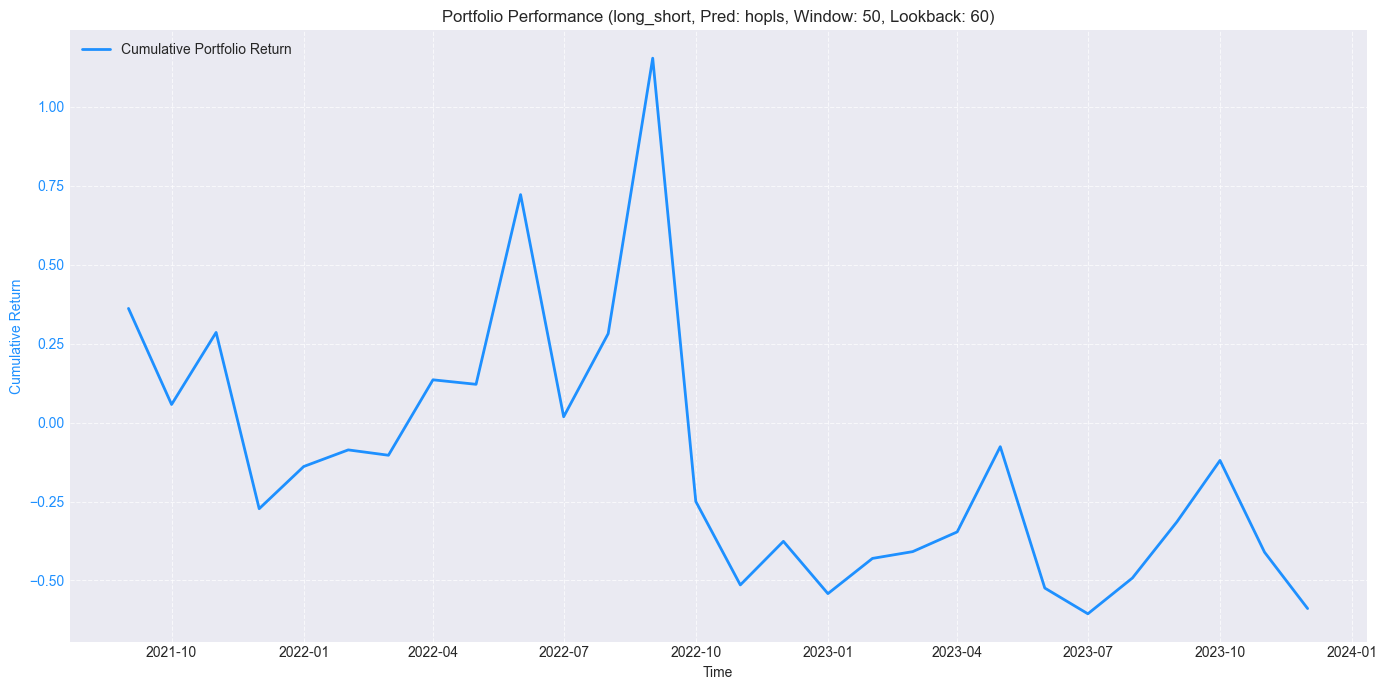

In [59]:
from model.prediction_engine import run_rolling_portfolio_backtest, plot_portfolio_performance
import warnings # Import the warnings module

# Define parameters for the backtest
pred_engine_window_size = 50 # Window size for the PredictionTestEngine
train_start_ratio = 0.9 

# Calculate pred_engine_train_start based on the ratio
# This is the index in X_all/Y_all where the *test set* begins.
# The training data for the first prediction will be X_all[pred_engine_train_start - pred_engine_window_size : pred_engine_train_start]
pred_engine_train_start = int(train_start_ratio * X_all.shape[0])

# Ensure pred_engine_train_start is valid
if pred_engine_train_start < pred_engine_window_size:
    print(f"Warning: Calculated pred_engine_train_start ({pred_engine_train_start}) is less than pred_engine_window_size ({pred_engine_window_size}). Adjusting to window_size.")
    pred_engine_train_start = pred_engine_window_size

if pred_engine_train_start >= X_all.shape[0]:
    raise ValueError(f"Error: pred_engine_train_start ({pred_engine_train_start}) must be less than total data length ({X_all.shape[0]}) to have a test set.")

asset_names = Y_df.columns.tolist() # Get asset names from your Y_df

# Parameters for portfolio construction
hist_data_lookback = 60             # Lookback period for historical data (used by HRP, MVO, MinVol)
portfolio_optimizer_method = "long_short"  # "top_k" or "long_short"
rebalance_freq = 1                 # Rebalance frequency

pred_method_name = "hopls"        # Prediction method
pred_method_kwargs = {
    "R": 30,
    "Ln": (3, 3),
    "epsilon": 1e-7,
}

# MVO-specific parameters (will be ignored by HRP but kept for potential switch back or if using MVO-based objectives)
mvo_target_objective = 'max_sharpe'
# EF common parameters (HRP doesn't use EfficientFrontier, but good to have if switching to MVO/MinVol)
ef_max_asset_weight = 0.1
ef_min_asset_weight = 0

print(f"X_all shape: {X_all.shape}")
print(f"Y_all shape: {Y_all.shape}")
print(f"Number of assets: {len(asset_names)}")
print(f"Prediction engine window size: {pred_engine_window_size}")
print(f"Calculated prediction engine train start index (start of test set): {pred_engine_train_start}")
print(f"Portfolio optimizer: {portfolio_optimizer_method}")
print(f"Historical data lookback: {hist_data_lookback}")
print(f"Rebalance frequency: {rebalance_freq}")
print(f"Prediction method: {pred_method_name}")
print(f"Prediction kwargs: {pred_method_kwargs}")

# Call the backtesting function
try:
    # Suppress warnings specifically from pypfopt for this block
    warnings.filterwarnings("ignore", module="pypfopt.*")
    
    portfolio_results_df = run_rolling_portfolio_backtest(
        X_features=X_all,
        y_returns_full=Y_all,
        pred_engine_window_size=pred_engine_window_size,
        asset_names=asset_names,
        hist_data_lookback=hist_data_lookback, # Using generic lookback
        pred_method_name=pred_method_name,
        pred_method_kwargs=pred_method_kwargs,
        pred_engine_train_start=pred_engine_train_start, 
        pred_engine_time_index=time_index_all, 
        pred_engine_n_jobs=7, # Set to > 1 for parallel prediction (e.g., 4 or os.cpu_count())
        
        portfolio_optimizer_method=portfolio_optimizer_method, 
        rank_k = 120,
        
        # rebalance_freq=rebalance_freq,
        
        # # MVO/EF specific parameters (passed but ignored by HRP logic in the function)
        # mvo_risk_free_rate_per_period=0.0, 
        # mvo_target_objective=mvo_target_objective,
        # ef_max_asset_weight=ef_max_asset_weight,
        # ef_min_asset_weight=ef_min_asset_weight,
        # ef_solver=None, 
        
        verbose=True # Keep this True for your custom function prints
    )

    print("\nPortfolio Backtest Results:")
    print(portfolio_results_df.head())

    # Plot the results
    plot_portfolio_performance(
        results_df=portfolio_results_df, 
        asset_names=asset_names,
        title_suffix=f"({portfolio_optimizer_method}, Pred: {pred_method_name}, Window: {pred_engine_window_size}, Lookback: {hist_data_lookback})"
    )

except ImportError as e:
    print(f"ImportError: {e}. Please ensure PyPortfolioOpt and other dependencies are installed.")
    print("You might need to run: pip install PyPortfolioOpt")
except ValueError as e:
    print(f"ValueError during backtest: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Reset warning filters to default after the try block
    warnings.resetwarnings()

# HOPLS-MILR

X_all shape: (275, 127, 38)
Y_all shape: (275, 127)
Number of assets: 127
Prediction engine window size: 50
Calculated prediction engine train start index (start of test set): 247
Portfolio optimizer: long_short
Historical data lookback: 60
Rebalance frequency: 1
Prediction method: hopls_milr
Prediction kwargs: {'R': 60, 'Ln': (7, 7), 'epsilon': 1e-06, 'lambda_X': 0.01, 'lambda_Y': 1e-07, 'alpha': 4}
Initializing PredictionTestEngine...
PredictionTestEngine initialized. Train start index: 247, Test indices count: 28
Running prediction method: hopls_milr to get expected returns (mu)...
run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=50, n_series=127, n_features=38
run_window: number of test windows=28


Parallel preds: 100%|██████████| 28/28 [06:39<00:00, 14.27s/it]


MILR components: 60
  P comp 0: [(127, 7), (38, 7)]
  P comp 1: [(127, 7), (38, 7)]
  P comp 2: [(127, 7), (38, 7)]
  P comp 3: [(127, 7), (38, 7)]
  P comp 4: [(127, 7), (38, 7)]
  P comp 5: [(127, 7), (38, 7)]
  P comp 6: [(127, 7), (38, 7)]
  P comp 7: [(127, 7), (38, 7)]
  P comp 8: [(127, 7), (38, 7)]
  P comp 9: [(127, 7), (38, 7)]
  P comp 10: [(127, 7), (38, 7)]
  P comp 11: [(127, 7), (38, 7)]
  P comp 12: [(127, 7), (38, 7)]
  P comp 13: [(127, 7), (38, 7)]
  P comp 14: [(127, 7), (38, 7)]
  P comp 15: [(127, 7), (38, 7)]
  P comp 16: [(127, 7), (38, 7)]
  P comp 17: [(127, 7), (38, 7)]
  P comp 18: [(127, 7), (38, 7)]
  P comp 19: [(127, 7), (38, 7)]
  P comp 20: [(127, 7), (38, 7)]
  P comp 21: [(127, 7), (38, 7)]
  P comp 22: [(127, 7), (38, 7)]
  P comp 23: [(127, 7), (38, 7)]
  P comp 24: [(127, 7), (38, 7)]
  P comp 25: [(127, 7), (38, 7)]
  P comp 26: [(127, 7), (38, 7)]
  P comp 27: [(127, 7), (38, 7)]
  P comp 28: [(127, 7), (38, 7)]
  P comp 29: [(127, 7), (38, 7)]


Rolling Backtest (long_short): 100%|██████████| 28/28 [00:00<00:00, 9120.18it/s]

Rolling backtest with long_short completed.

Portfolio Backtest Results:
            portfolio_return  weight_1078  weight_1209  weight_1300  \
2021-09-01          0.060195     0.008333     0.008333    -0.008333   
2021-10-01          0.011359    -0.008333     0.008333    -0.008333   
2021-11-01          0.056829    -0.008333     0.008333    -0.008333   
2021-12-01         -0.231149    -0.008333     0.000000    -0.008333   
2022-01-01         -0.007467     0.008333     0.008333    -0.008333   

            weight_1380  weight_1598  weight_1686  weight_1794  weight_1913  \
2021-09-01     0.008333    -0.008333     0.000000    -0.008333     0.008333   
2021-10-01     0.008333    -0.008333     0.008333     0.000000     0.008333   
2021-11-01     0.008333    -0.008333     0.008333     0.008333     0.008333   
2021-12-01     0.008333    -0.008333    -0.008333    -0.008333     0.008333   
2022-01-01     0.008333    -0.008333     0.008333     0.008333     0.008333   

            weight_1988  

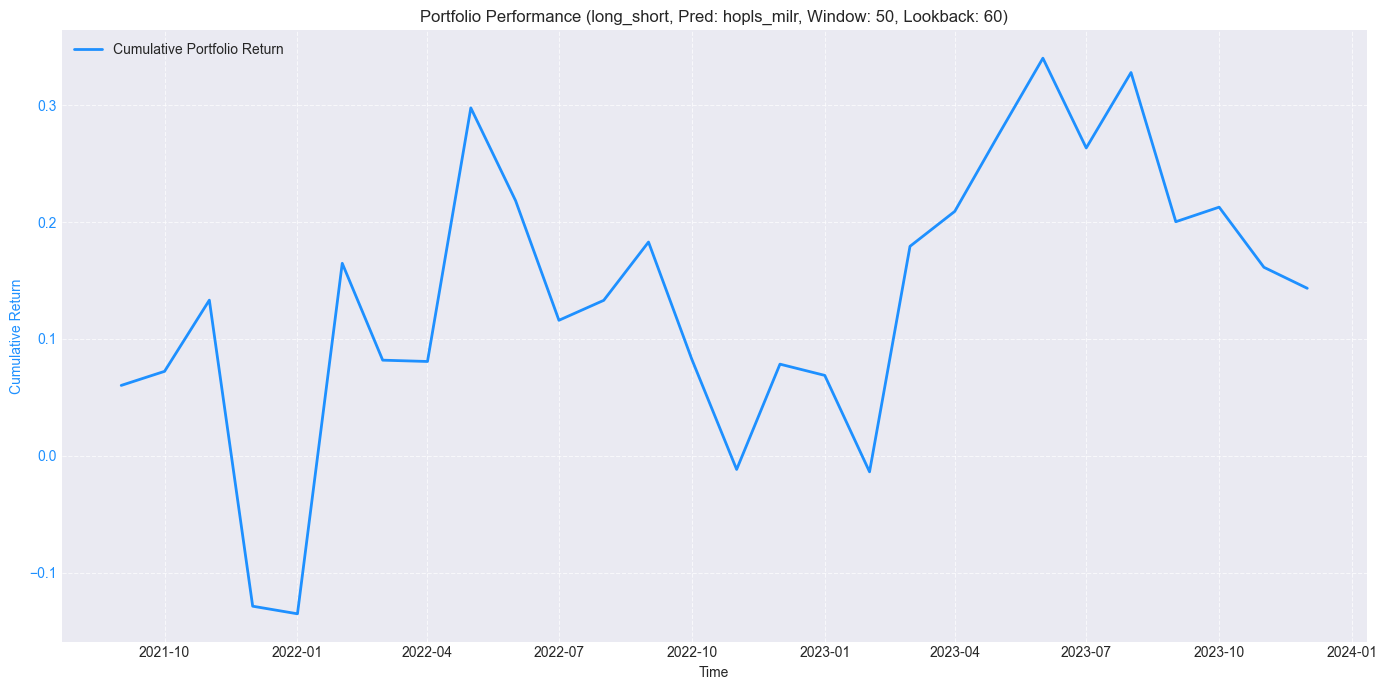

In [66]:
from model.prediction_engine import run_rolling_portfolio_backtest, plot_portfolio_performance
import warnings # Import the warnings module

# Define parameters for the backtest
pred_engine_window_size = 50 # Window size for the PredictionTestEngine
train_start_ratio = 0.9 

# Calculate pred_engine_train_start based on the ratio
# This is the index in X_all/Y_all where the *test set* begins.
# The training data for the first prediction will be X_all[pred_engine_train_start - pred_engine_window_size : pred_engine_train_start]
pred_engine_train_start = int(train_start_ratio * X_all.shape[0])

# Ensure pred_engine_train_start is valid
if pred_engine_train_start < pred_engine_window_size:
    print(f"Warning: Calculated pred_engine_train_start ({pred_engine_train_start}) is less than pred_engine_window_size ({pred_engine_window_size}). Adjusting to window_size.")
    pred_engine_train_start = pred_engine_window_size

if pred_engine_train_start >= X_all.shape[0]:
    raise ValueError(f"Error: pred_engine_train_start ({pred_engine_train_start}) must be less than total data length ({X_all.shape[0]}) to have a test set.")

asset_names = Y_df.columns.tolist() # Get asset names from your Y_df

# Parameters for portfolio construction
hist_data_lookback = 60             # Lookback period for historical data (used by HRP, MVO, MinVol)
portfolio_optimizer_method = "long_short"  # "top_k" or "long_short"
rebalance_freq = 1                 # Rebalance frequency

pred_method_name = "hopls_milr"        # Prediction method
pred_method_kwargs = {
    "R": 60,
    "Ln": (7, 7),
    "epsilon": 1e-6,
    "lambda_X": 1e-2,
    "lambda_Y": 1e-7,
    "alpha": 4
    
}

# , R=60, Ln=(7, 7), epsilon=1e-5, verbose=True, n_jobs=7, lambda_X = 1e-2, lambda_Y = 1e-7, alpha=4.0
# R=32, Ln=(5, 5), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 0.001, lambda_Y = 0.001, alpha=0.1
# R = 30, Ln = (5,5), epsilon = 1e-6, verbose=True, n_jobs=7, lambda_X = 0.001, lambda_Y = 0.001, alpha=0.1
# , R=40, Ln=(1, 1), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 1e-5, lambda_Y = 1e-5, alpha=1.1,

# MVO-specific parameters (will be ignored by HRP but kept for potential switch back or if using MVO-based objectives)
mvo_target_objective = 'max_sharpe'
# EF common parameters (HRP doesn't use EfficientFrontier, but good to have if switching to MVO/MinVol)
ef_max_asset_weight = 0.2
ef_min_asset_weight = 0

print(f"X_all shape: {X_all.shape}")
print(f"Y_all shape: {Y_all.shape}")
print(f"Number of assets: {len(asset_names)}")
print(f"Prediction engine window size: {pred_engine_window_size}")
print(f"Calculated prediction engine train start index (start of test set): {pred_engine_train_start}")
print(f"Portfolio optimizer: {portfolio_optimizer_method}")
print(f"Historical data lookback: {hist_data_lookback}")
print(f"Rebalance frequency: {rebalance_freq}")
print(f"Prediction method: {pred_method_name}")
print(f"Prediction kwargs: {pred_method_kwargs}")

# Call the backtesting function
try:
    # Suppress warnings specifically from pypfopt for this block
    warnings.filterwarnings("ignore", module="pypfopt.*")
    
    portfolio_results_df = run_rolling_portfolio_backtest(
        X_features=X_all,
        y_returns_full=Y_all,
        pred_engine_window_size=pred_engine_window_size,
        asset_names=asset_names,
        hist_data_lookback=hist_data_lookback, # Using generic lookback
        pred_method_name=pred_method_name,
        pred_method_kwargs=pred_method_kwargs,
        pred_engine_train_start=pred_engine_train_start, 
        pred_engine_time_index=time_index_all, 
        pred_engine_n_jobs=7, # Set to > 1 for parallel prediction (e.g., 4 or os.cpu_count())
        
        portfolio_optimizer_method=portfolio_optimizer_method, 
        rank_k = 60,
        
        # rebalance_freq=rebalance_freq,
        
        # # MVO/EF specific parameters (passed but ignored by HRP logic in the function)
        # mvo_risk_free_rate_per_period=0.0, 
        # mvo_target_objective=mvo_target_objective,
        # ef_max_asset_weight=ef_max_asset_weight,
        # ef_min_asset_weight=ef_min_asset_weight,
        # ef_solver=None, 
        
        verbose=True # Keep this True for your custom function prints
    )

    print("\nPortfolio Backtest Results:")
    print(portfolio_results_df.head())

    # Plot the results
    plot_portfolio_performance(
        results_df=portfolio_results_df, 
        asset_names=asset_names,
        title_suffix=f"({portfolio_optimizer_method}, Pred: {pred_method_name}, Window: {pred_engine_window_size}, Lookback: {hist_data_lookback})"
    )

except ImportError as e:
    print(f"ImportError: {e}. Please ensure PyPortfolioOpt and other dependencies are installed.")
    print("You might need to run: pip install PyPortfolioOpt")
except ValueError as e:
    print(f"ValueError during backtest: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Reset warning filters to default after the try block
    warnings.resetwarnings()

# HOPLS-Ridge (Naive)

X_all shape: (275, 127, 38)
Y_all shape: (275, 127)
Number of assets: 127
Prediction engine window size: 50
Calculated prediction engine train start index (start of test set): 247
Portfolio optimizer: long_short
Historical data lookback: 60
Rebalance frequency: 1
Prediction method: hopls_ridge
Prediction kwargs: {'R': 30, 'Ln': (3, 3), 'epsilon': 1e-05, 'lambda_X': 0.01, 'lambda_Y': 1e-07}
Initializing PredictionTestEngine...
PredictionTestEngine initialized. Train start index: 247, Test indices count: 28
Running prediction method: hopls_ridge to get expected returns (mu)...
run_window: X_all shape (275, 127, 38), y_all shape (275, 127)
run_window: window_size=50, n_series=127, n_features=38
run_window: number of test windows=28


Parallel preds: 100%|██████████| 28/28 [02:01<00:00,  4.34s/it]


Components: 30
P shapes per component:
  Comp 0: [(127, 3), (38, 3)]
  Comp 1: [(127, 3), (38, 3)]
  Comp 2: [(127, 3), (38, 3)]
  Comp 3: [(127, 3), (38, 3)]
  Comp 4: [(127, 3), (38, 3)]
  Comp 5: [(127, 3), (38, 3)]
  Comp 6: [(127, 3), (38, 3)]
  Comp 7: [(127, 3), (38, 3)]
  Comp 8: [(127, 3), (38, 3)]
  Comp 9: [(127, 3), (38, 3)]
  Comp 10: [(127, 3), (38, 3)]
  Comp 11: [(127, 3), (38, 3)]
  Comp 12: [(127, 3), (38, 3)]
  Comp 13: [(127, 3), (38, 3)]
  Comp 14: [(127, 3), (38, 3)]
  Comp 15: [(127, 3), (38, 3)]
  Comp 16: [(127, 3), (38, 3)]
  Comp 17: [(127, 3), (38, 3)]
  Comp 18: [(127, 3), (38, 3)]
  Comp 19: [(127, 3), (38, 3)]
  Comp 20: [(127, 3), (38, 3)]
  Comp 21: [(127, 3), (38, 3)]
  Comp 22: [(127, 3), (38, 3)]
  Comp 23: [(127, 3), (38, 3)]
  Comp 24: [(127, 3), (38, 3)]
  Comp 25: [(127, 3), (38, 3)]
  Comp 26: [(127, 3), (38, 3)]
  Comp 27: [(127, 3), (38, 3)]
  Comp 28: [(127, 3), (38, 3)]
  Comp 29: [(127, 3), (38, 3)]
Q_mat shape: (127, 30), D shape: (30, 30)

Rolling Backtest (long_short): 100%|██████████| 28/28 [00:00<00:00, 11873.47it/s]

Rolling backtest with long_short completed.

Portfolio Backtest Results:
            portfolio_return  weight_1078  weight_1209  weight_1300  \
2021-09-01          0.238156    -0.008333     0.008333     0.000000   
2021-10-01         -0.102660    -0.008333     0.008333     0.000000   
2021-11-01         -0.111422    -0.008333     0.008333    -0.008333   
2021-12-01         -0.199147    -0.008333     0.008333    -0.008333   
2022-01-01         -0.145705    -0.008333     0.000000    -0.008333   

            weight_1380  weight_1598  weight_1686  weight_1794  weight_1913  \
2021-09-01     0.008333    -0.008333     0.008333     0.008333    -0.008333   
2021-10-01     0.008333    -0.008333     0.008333     0.008333     0.000000   
2021-11-01     0.008333    -0.008333    -0.008333     0.008333     0.008333   
2021-12-01     0.008333     0.008333    -0.008333     0.008333    -0.008333   
2022-01-01    -0.008333    -0.008333    -0.008333     0.000000     0.008333   

            weight_1988  

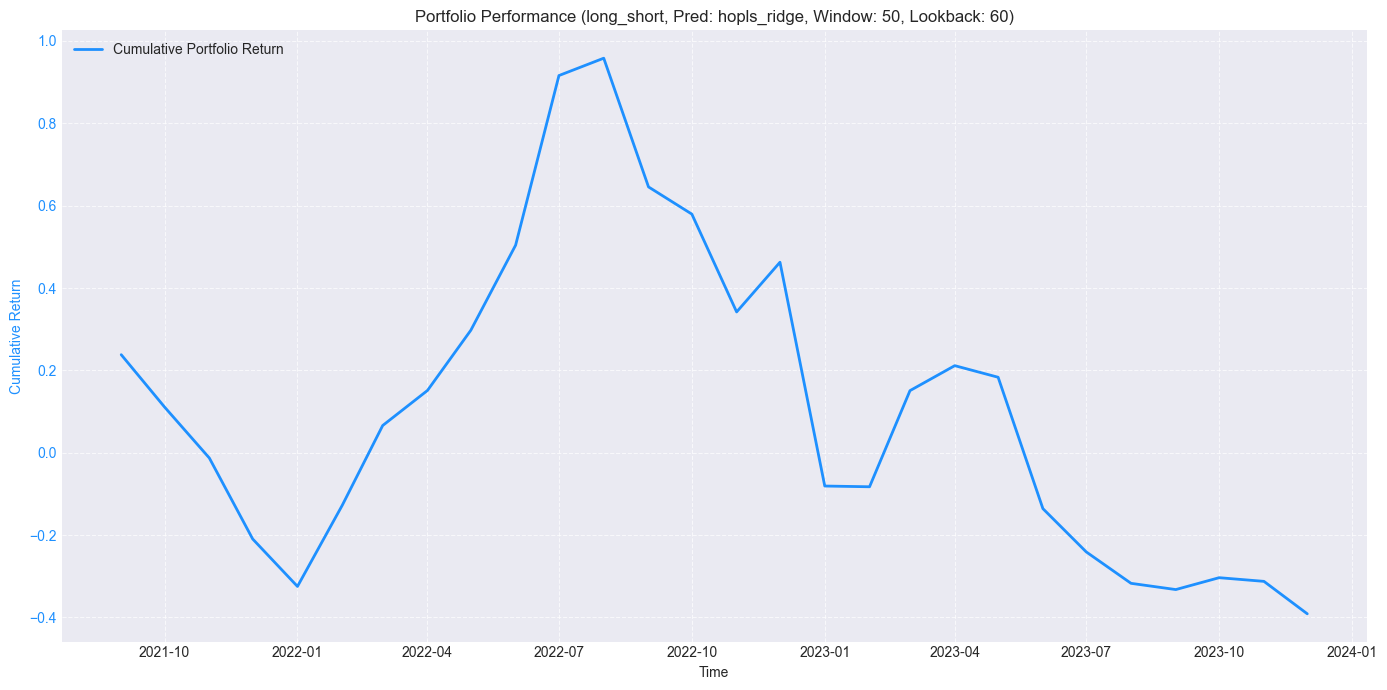

In [68]:
from model.prediction_engine import run_rolling_portfolio_backtest, plot_portfolio_performance
import warnings # Import the warnings module

# Define parameters for the backtest
pred_engine_window_size = 50 # Window size for the PredictionTestEngine
train_start_ratio = 0.9 

# Calculate pred_engine_train_start based on the ratio
# This is the index in X_all/Y_all where the *test set* begins.
# The training data for the first prediction will be X_all[pred_engine_train_start - pred_engine_window_size : pred_engine_train_start]
pred_engine_train_start = int(train_start_ratio * X_all.shape[0])

# Ensure pred_engine_train_start is valid
if pred_engine_train_start < pred_engine_window_size:
    print(f"Warning: Calculated pred_engine_train_start ({pred_engine_train_start}) is less than pred_engine_window_size ({pred_engine_window_size}). Adjusting to window_size.")
    pred_engine_train_start = pred_engine_window_size

if pred_engine_train_start >= X_all.shape[0]:
    raise ValueError(f"Error: pred_engine_train_start ({pred_engine_train_start}) must be less than total data length ({X_all.shape[0]}) to have a test set.")

asset_names = Y_df.columns.tolist() # Get asset names from your Y_df

# Parameters for portfolio construction
hist_data_lookback = 60             # Lookback period for historical data (used by HRP, MVO, MinVol)
portfolio_optimizer_method = "long_short"  # "top_k" or "long_short"
rebalance_freq = 1                 # Rebalance frequency

pred_method_name = "hopls_ridge"        # Prediction method
pred_method_kwargs = {
    "R": 30,
    "Ln": (3, 3),
    "epsilon": 1e-5,
    "lambda_X": 1e-2,
    "lambda_Y": 1e-7,
}

#    , R=30, Ln=(3, 3), epsilon=1e-5, verbose=True, n_jobs=7, lambda_X = 1e-2, lambda_Y = 1e-7
# , R=60, Ln=(7, 7), epsilon=1e-5, verbose=True, n_jobs=7, lambda_X = 1e-2, lambda_Y = 1e-7, alpha=4.0
# R=32, Ln=(5, 5), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 0.001, lambda_Y = 0.001, alpha=0.1
# R = 30, Ln = (5,5), epsilon = 1e-6, verbose=True, n_jobs=7, lambda_X = 0.001, lambda_Y = 0.001, alpha=0.1
# , R=40, Ln=(1, 1), epsilon=1e-6, verbose=True, n_jobs=7, lambda_X = 1e-5, lambda_Y = 1e-5, alpha=1.1,

# MVO-specific parameters (will be ignored by HRP but kept for potential switch back or if using MVO-based objectives)
mvo_target_objective = 'max_sharpe'
# EF common parameters (HRP doesn't use EfficientFrontier, but good to have if switching to MVO/MinVol)
ef_max_asset_weight = 0.2
ef_min_asset_weight = 0

print(f"X_all shape: {X_all.shape}")
print(f"Y_all shape: {Y_all.shape}")
print(f"Number of assets: {len(asset_names)}")
print(f"Prediction engine window size: {pred_engine_window_size}")
print(f"Calculated prediction engine train start index (start of test set): {pred_engine_train_start}")
print(f"Portfolio optimizer: {portfolio_optimizer_method}")
print(f"Historical data lookback: {hist_data_lookback}")
print(f"Rebalance frequency: {rebalance_freq}")
print(f"Prediction method: {pred_method_name}")
print(f"Prediction kwargs: {pred_method_kwargs}")

# Call the backtesting function
try:
    # Suppress warnings specifically from pypfopt for this block
    warnings.filterwarnings("ignore", module="pypfopt.*")
    
    portfolio_results_df = run_rolling_portfolio_backtest(
        X_features=X_all,
        y_returns_full=Y_all,
        pred_engine_window_size=pred_engine_window_size,
        asset_names=asset_names,
        hist_data_lookback=hist_data_lookback, # Using generic lookback
        pred_method_name=pred_method_name,
        pred_method_kwargs=pred_method_kwargs,
        pred_engine_train_start=pred_engine_train_start, 
        pred_engine_time_index=time_index_all, 
        pred_engine_n_jobs=7, # Set to > 1 for parallel prediction (e.g., 4 or os.cpu_count())
        
        portfolio_optimizer_method=portfolio_optimizer_method, 
        rank_k = 60,
        
        # rebalance_freq=rebalance_freq,
        
        # # MVO/EF specific parameters (passed but ignored by HRP logic in the function)
        # mvo_risk_free_rate_per_period=0.0, 
        # mvo_target_objective=mvo_target_objective,
        # ef_max_asset_weight=ef_max_asset_weight,
        # ef_min_asset_weight=ef_min_asset_weight,
        # ef_solver=None, 
        
        verbose=True # Keep this True for your custom function prints
    )

    print("\nPortfolio Backtest Results:")
    print(portfolio_results_df.head())

    # Plot the results
    plot_portfolio_performance(
        results_df=portfolio_results_df, 
        asset_names=asset_names,
        title_suffix=f"({portfolio_optimizer_method}, Pred: {pred_method_name}, Window: {pred_engine_window_size}, Lookback: {hist_data_lookback})"
    )

except ImportError as e:
    print(f"ImportError: {e}. Please ensure PyPortfolioOpt and other dependencies are installed.")
    print("You might need to run: pip install PyPortfolioOpt")
except ValueError as e:
    print(f"ValueError during backtest: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Reset warning filters to default after the try block
    warnings.resetwarnings()



---
# Test New Feature

In [ ]:
from model.prediction_engine import run_rolling_portfolio_backtest, plot_portfolio_performance
import warnings # Import the warnings module

# Define parameters for the backtest
pred_engine_window_size = 50 # Window size for the PredictionTestEngine
train_start_ratio = 0.8 # Use 70% of data for the initial training period of PredictionTestEngine

# Calculate pred_engine_train_start based on the ratio
# This is the index in X_all/Y_all where the *test set* begins.
# The training data for the first prediction will be X_all[pred_engine_train_start - pred_engine_window_size : pred_engine_train_start]
pred_engine_train_start = int(train_start_ratio * X_all.shape[0])

# Ensure pred_engine_train_start is valid
if pred_engine_train_start < pred_engine_window_size:
    print(f"Warning: Calculated pred_engine_train_start ({pred_engine_train_start}) is less than pred_engine_window_size ({pred_engine_window_size}). Adjusting to window_size.")
    pred_engine_train_start = pred_engine_window_size

if pred_engine_train_start >= X_all.shape[0]:
    raise ValueError(f"Error: pred_engine_train_start ({pred_engine_train_start}) must be less than total data length ({X_all.shape[0]}) to have a test set.")

asset_names = Y_df.columns.tolist() # Get asset names from your Y_df

# Parameters for portfolio construction
hist_data_lookback = 60             # Lookback period for historical data (used by HRP, MVO, MinVol)
portfolio_optimizer_method = "long_short"  # "top_k" or "long_short"
rebalance_freq = 1                 # Rebalance frequency

pred_method_name = "ridge"        # Prediction method
pred_method_kwargs= {}

# MVO-specific parameters (will be ignored by HRP but kept for potential switch back or if using MVO-based objectives)
mvo_target_objective = 'max_sharpe'
# EF common parameters (HRP doesn't use EfficientFrontier, but good to have if switching to MVO/MinVol)
ef_max_asset_weight = 0.1
ef_min_asset_weight = 0

print(f"X_all shape: {X_all.shape}")
print(f"Y_all shape: {Y_all.shape}")
print(f"Number of assets: {len(asset_names)}")
print(f"Prediction engine window size: {pred_engine_window_size}")
print(f"Calculated prediction engine train start index (start of test set): {pred_engine_train_start}")
print(f"Portfolio optimizer: {portfolio_optimizer_method}")
print(f"Historical data lookback: {hist_data_lookback}")
print(f"Rebalance frequency: {rebalance_freq}")
print(f"Prediction method: {pred_method_name}")
print(f"Prediction kwargs: {pred_method_kwargs}")

# 1) Precompute predictions just once
from model.prediction_engine import PredictionTestEngine

engine = PredictionTestEngine(
    X_all=X_all,
    y_all=Y_all,
    window_size=pred_engine_window_size,
    train_start=pred_engine_train_start,
    time_index=time_index_all
)

predicted_returns_for_mvo, actual_returns_for_pnl, time_index_for_results, pred_metrics = \
    engine.run_window(
        method=pred_method_name,
        verbose=False,
        n_jobs=pred_engine_n_jobs,
        **(pred_method_kwargs or {})
    )

print("Precomputed predictions shape:", predicted_returns_for_mvo.shape)
print("Metrics from prediction run:", pred_metrics)


In [ ]:
# 2) Run backtests on the precomputed predictions
from model.prediction_engine import backtest_from_predictions

# Example: evaluate top_k strategy
df_topk = backtest_from_predictions(
    predicted_returns_for_mvo,
    actual_returns_for_pnl,
    time_index_for_results,
    asset_names,
    hist_data_lookback,
    portfolio_optimizer_method="top_k",
    rank_k=20,
    rebalance_freq=rebalance_freq,
    verbose=False
)
print("Top-K backtest results:")
display(df_topk.head())
plot_portfolio_performance(
    results_df=df_topk,
    asset_names=asset_names,
    title_suffix=f"(top_k, K=20)"
)

# Example: evaluate long_short strategy
 df_ls = backtest_from_predictions(
    predicted_returns_for_mvo,
    actual_returns_for_pnl,
    time_index_for_results,
    asset_names,
    hist_data_lookback,
    portfolio_optimizer_method="long_short",
    rank_k=20,
    rebalance_freq=rebalance_freq,
    verbose=False
)
print("Long/Short backtest results:")
display(df_ls.head())
plot_portfolio_performance(
    results_df=df_ls,
    asset_names=asset_names,
    title_suffix=f"(long_short, K=20)"
)

# Archive

Weight summary statistics (per asset):


,count,mean,std,min,25%,50%,75%,max
weight_1078,55.0,-0.007121,0.004368,-0.008333,-0.008333,-0.008333,-0.008333,0.008333
weight_1209,55.0,-0.007121,0.004063,-0.008333,-0.008333,-0.008333,-0.008333,0.008333
weight_1300,55.0,-0.003333,0.007454,-0.008333,-0.008333,-0.008333,0.008333,0.008333
weight_1380,55.0,-0.001212,0.008086,-0.008333,-0.008333,-0.008333,0.008333,0.008333
weight_1598,55.0,-0.005909,0.005930,-0.008333,-0.008333,-0.008333,-0.008333,0.008333
...,...,...,...,...,...,...,...,...
weight_29392,55.0,-0.003636,0.007482,-0.008333,-0.008333,-0.008333,0.008333,0.008333
weight_29830,55.0,0.005606,0.005795,-0.008333,0.008333,0.008333,0.008333,0.008333
weight_30477,55.0,0.007424,0.003467,-0.008333,0.008333,0.008333,0.008333,0.008333
weight_61811,55.0,0.001667,0.007590,-0.008333,-0.008333,0.008333,0.008333,0.008333



Weights for first 5 periods:


,weight_1078,weight_1209,weight_1300,weight_1380,weight_1598,weight_1686,weight_1794,weight_1913,weight_1988,weight_2086,...,weight_23978,weight_25870,weight_28176,weight_28940,weight_29217,weight_29392,weight_29830,weight_30477,weight_61811,weight_66290
year_month,,,,,,,,,,,,,,,,,,,,,
2019-06-01,-0.008333,-0.008333,-0.008333,0.008333,-0.008333,0.008333,0.008333,-0.008333,-0.008333,-0.008333,...,0.008333,-0.008333,-0.008333,-0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2019-07-01,-0.008333,0.008333,-0.008333,0.000000,-0.008333,0.000000,-0.008333,-0.008333,0.008333,-0.008333,...,0.008333,-0.008333,0.000000,-0.008333,0.008333,-0.008333,0.008333,0.008333,0.008333,0.008333
2019-08-01,-0.008333,-0.008333,0.008333,-0.008333,-0.008333,-0.008333,0.008333,0.000000,-0.008333,0.008333,...,-0.008333,-0.008333,0.008333,-0.008333,-0.008333,-0.008333,0.000000,0.008333,0.008333,-0.008333
2019-09-01,0.008333,-0.008333,0.008333,-0.008333,0.008333,0.000000,0.008333,-0.008333,0.008333,-0.008333,...,-0.008333,-0.008333,0.008333,-0.008333,-0.008333,-0.008333,0.008333,-0.008333,0.008333,0.008333
2019-10-01,-0.008333,-0.008333,-0.008333,-0.008333,-0.008333,0.008333,0.000000,-0.008333,-0.008333,-0.008333,...,0.008333,0.008333,-0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,-0.008333


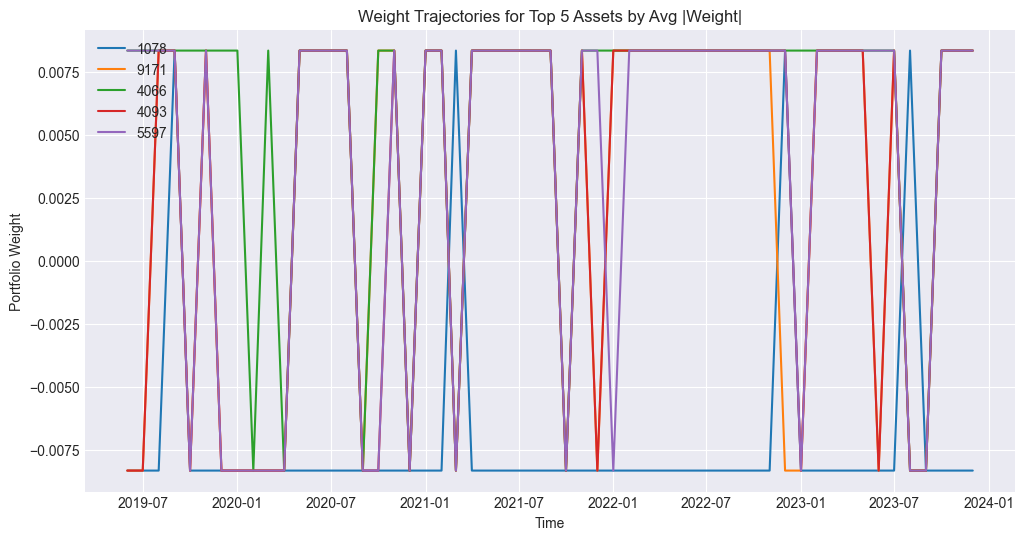

In [47]:
# 1) Summarize weight distributions
wt_cols = [c for c in portfolio_results_df.columns if c.startswith('weight_')]
# Transpose describe() for readability
weight_stats = portfolio_results_df[wt_cols].describe().T
print("Weight summary statistics (per asset):")
display(weight_stats)

# Show weights for first 5 periods
print("\nWeights for first 5 periods:")
display(portfolio_results_df[wt_cols].head())

# 2) Plot weight trajectories for the 5 assets with largest average absolute weight
import matplotlib.pyplot as plt

# compute average absolute weight per asset
avg_abs = portfolio_results_df[wt_cols].abs().mean().sort_values(ascending=False)
top5 = avg_abs.index[:5]
fig, ax = plt.subplots(figsize=(12, 6))
for col in top5:
    ax.plot(portfolio_results_df.index, portfolio_results_df[col], label=col.replace('weight_',''))
ax.set_title("Weight Trajectories for Top 5 Assets by Avg |Weight|")
ax.set_xlabel("Time")
ax.set_ylabel("Portfolio Weight")
ax.legend(loc="upper left")
plt.show()

In [ ]:
# 1) Summarize weight distributions
wt_cols = [c for c in portfolio_results_df.columns if c.startswith('weight_')]
# Transpose describe() for readability
weight_stats = portfolio_results_df[wt_cols].describe().T
print("Weight summary statistics (per asset):")
display(weight_stats)

# Show weights for first 5 periods
print("\nWeights for first 5 periods:")
display(portfolio_results_df[wt_cols].head())

# 2) Plot weight trajectories for the 5 assets with largest average absolute weight
import matplotlib.pyplot as plt

# compute average absolute weight per asset
avg_abs = portfolio_results_df[wt_cols].abs().mean().sort_values(ascending=False)
top5 = avg_abs.index[:5]
fig, ax = plt.subplots(figsize=(12, 6))
for col in top5:
    ax.plot(portfolio_results_df.index, portfolio_results_df[col], label=col.replace('weight_',''))
ax.set_title("Weight Trajectories for Top 5 Assets by Avg |Weight|")
ax.set_xlabel("Time")
ax.set_ylabel("Portfolio Weight")
ax.legend(loc="upper left")
plt.show()